In [1]:
# link: https://www.kaggle.com/code/krisnaik/nn-audio-emotion

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from joblib import dump, load

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

D:\Anaconda\lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
D:\Anaconda\lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


In [7]:
Crema = "./Crema/AudioWAV/"
Tess = "./Tess/TESS/TESS Toronto emotional speech set data/"
Savee = "./Savee/ALL/"

# 1 Ravdess
DataSet1 = "./ravdess-emotional-speech-audio/"

data1FilePaths = os.listdir(DataSet1)

fileEmotion = []
filePath = []

for dir in data1FilePaths:
    person = os.listdir(DataSet1 + dir)
    for file in person:
        part = file.split('.')[0]
        part = part.split('-')
        fileEmotion.append(int(part[2]))
        filePath.append(DataSet1 + dir + '/' + file)

emotionDF = pd.DataFrame(fileEmotion, columns=['emotions'])
pathDF = pd.DataFrame(filePath, columns=['path'])
set1DF = pd.concat([emotionDF, pathDF], axis=1)

set1DF.emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
set1DF.head()

# 2 Savee
DataSet2 = "./Savee/ALL/"

data2FilePaths = os.listdir(DataSet2)

fileEmotion = []
filePath = []
for file in data2FilePaths:
    filePath.append(DataSet2 + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele == 'n':
        fileEmotion.append('neutral')
    elif ele == 'h':
        fileEmotion.append('happy')
    elif ele == 'sa':
        fileEmotion.append('sad')
    elif ele == 'a':
        fileEmotion.append('angry')
    elif ele == 'f':
        fileEmotion.append('fear')
    elif ele == 'd':
        fileEmotion.append('disgust')
    else:
        fileEmotion.append('surprise')
        
emotionDF = pd.DataFrame(fileEmotion, columns=['emotions'])
pathDF = pd.DataFrame(filePath, columns=['path'])
set2DF = pd.concat([emotionDF, pathDF], axis=1)
set2DF.head()

# 3 TESS
DataSet3 = "./Tess/TESS/TESS Toronto emotional speech set data/"

data3FilePaths = os.listdir(DataSet3)

fileEmotion = []
filePath = []
for dir in data3FilePaths:
    directories = os.listdir(DataSet3 + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            fileEmotion.append('surprise')
        else:
            fileEmotion.append(part)
        filePath.append(DataSet3 + dir + '/' + file)
        
emotionDF = pd.DataFrame(fileEmotion, columns=['emotions'])
pathDF = pd.DataFrame(filePath, columns=['path'])
set3DF = pd.concat([emotionDF, pathDF], axis=1)
set3DF.head()

# All data
pathsData = pd.concat([set1DF, set2DF, set3DF], axis = 0)
pathsData.to_csv("PathsData.csv",index=False)
pathsData.head()

,emotions,path
0,neutral,./ravdess-emotional-speech-audio/Actor_01/03-0...
1,neutral,./ravdess-emotional-speech-audio/Actor_01/03-0...
2,neutral,./ravdess-emotional-speech-audio/Actor_01/03-0...
3,neutral,./ravdess-emotional-speech-audio/Actor_01/03-0...
4,calm,./ravdess-emotional-speech-audio/Actor_01/03-0...


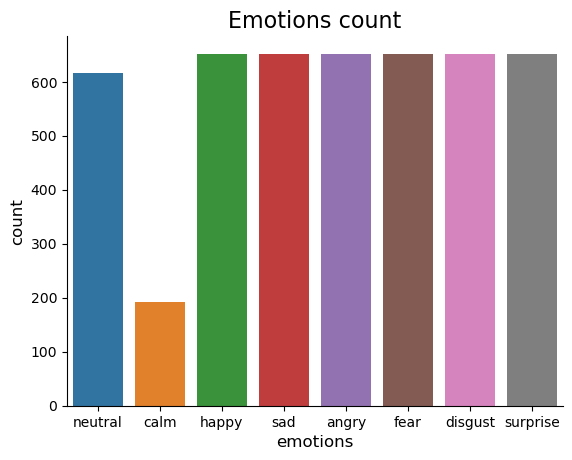

AttributeError: module 'matplotlib' has no attribute 'pyplot'

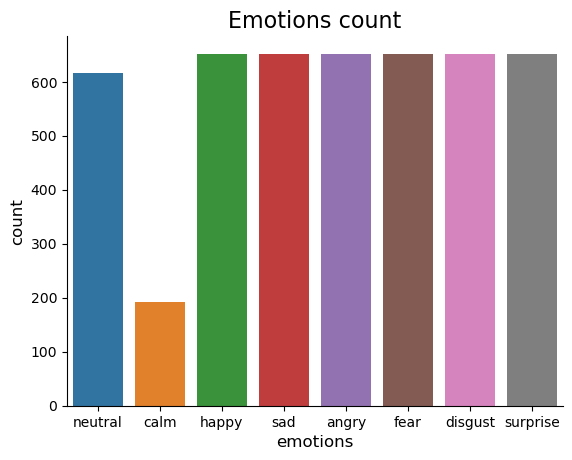

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [8]:
# DataEdit
plt.title('Emotions count', size=16)
sns.countplot(x=pathsData["emotions"])
plt.ylabel('count', size=12)
plt.xlabel('emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
# Data Edit function
def add_noise(data):
    noise = 0.03*np.random.uniform()*np.amax(data)
    data = data + noise*np.random.normal(size=data.shape[0])
    return data

def stretch_audio(data, rate=0.7):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_correct(data, sampling_rate, pitch_factor=0.75):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(pathsData.path)[1]
data, sample_rate = librosa.load(path)

# prepare data functions
def prepare_features(data):
    result = np.array([])
    ZeroCrossingRate = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, ZeroCrossingRate))

    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    rootMeanSquare = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rootMeanSquare))

    mSpect = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mSpect))
    
    return result

def prepare_all_data(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    clearData = prepare_features(data)
    result = np.array(clearData)
    
    noiseDataTmp = add_noise(data)
    noiseData = prepare_features(noiseDataTmp)
    result = np.vstack((result, noiseData))
    
    stretchData = stretch_audio(data)
    stretchPitchDataTmp = pitch_correct(stretchData, sample_rate)
    stretchPitchData = prepare_features(stretchPitchDataTmp)
    result = np.vstack((result, stretchPitchData))
    
    return result

In [10]:
# prepare training data
X, Y = [], []
for path, emotion in zip(pathsData.path, pathsData.emotions):
    feature = prepare_all_data(path)
    for el in feature:
        X.append(el)
        Y.append(emotion)

featuresArray = pd.DataFrame(X)
featuresArray['labels'] = Y
featuresArray.to_csv('features.csv', index=False)
featuresArray.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,0.000007,0.000005,4.245834e-07,neutral
1,0.286680,0.785113,0.788387,0.774674,0.795440,0.757274,0.667569,0.699091,0.736416,0.754040,...,1.001234e-05,9.189153e-06,7.903646e-06,7.806976e-06,1.015315e-05,1.325073e-05,0.000013,0.000011,5.881678e-06,neutral
2,0.196879,0.655903,0.730444,0.714663,0.721860,0.677184,0.671172,0.682512,0.717198,0.727892,...,9.427337e-07,8.627209e-07,6.665452e-07,5.205779e-07,4.046995e-07,9.238336e-07,0.000002,0.000001,6.608222e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034949e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640183e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.328853,0.809936,0.828554,0.807018,0.793390,0.802351,0.711955,0.665304,0.724289,0.758132,...,1.223142e-04,1.183060e-04,1.216131e-04,1.241974e-04,1.195764e-04,1.216485e-04,0.000130,0.000116,1.084049e-04,neutral


In [11]:
X = featuresArray.iloc[: ,:-1].values
Y = featuresArray['labels'].values

enc = OneHotEncoder()
Y = enc.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

sca_st = StandardScaler()
x_train = sca_st.fit_transform(x_train)
x_test = sca_st.transform(x_test)
dump(sca_st, 'std_scaler.bin', compress=True)

#print(sca_st.mean_)
#print(sca_st.var_)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162, 1), (10620, 8), (3540, 162, 1), (3540, 8))

In [12]:
#NN
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

Epoch 34/50
166/166 [==============================] - 9s 56ms/step - loss: 0.2803 - accuracy: 0.9024 - val_loss: 0.5453 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 35/50
166/166 [==============================] - 9s 56ms/step - loss: 0.1835 - accuracy: 0.9359 - val_loss: 0.6120 - val_accuracy: 0.8511 - lr: 4.0000e-04
Epoch 36/50
166/166 [==============================] - 9s 55ms/step - loss: 0.1545 - accuracy: 0.9452 - val_loss: 0.5983 - val_accuracy: 0.8573 - lr: 4.0000e-04
Epoch 37/50
166/166 [==============================] - 9s 55ms/step - loss: 0.1419 - accuracy: 0.9497 - val_loss: 0.6260 - val_accuracy: 0.8599 - lr: 4.0000e-04
Epoch 38/50
166/166 [==============================] - 9s 55ms/step - loss: 0.1299 - accuracy: 0.9551 - val_loss: 0.6395 - val_accuracy: 0.8621 - lr: 4.0000e-04
Epoch 39/50
166/166 [==============================] - 9s 56ms/step - loss: 0.1322 - accuracy: 0.9558 - val_loss: 0.6079 - val_accuracy: 0.8672 - lr: 4.0000e-04
Epoch 40/50
166/166 [=================

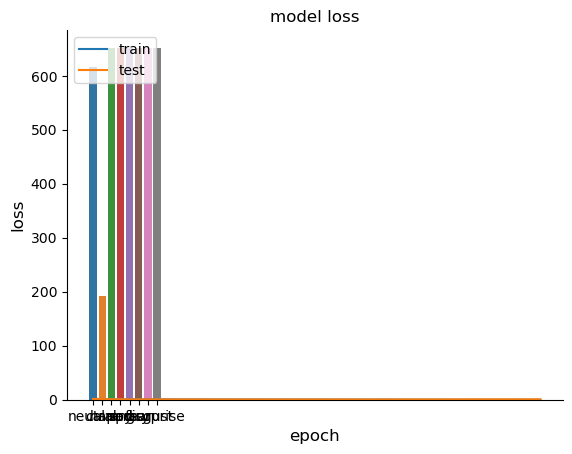

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
modelName = 'AudioModel.h5'
saveTo = os.path.join(os.getcwd(), 'myModels')

if not os.path.isdir(saveTo):
    os.makedirs(saveTo)
pathToModel = os.path.join(saveTo, modelName)
model.save(pathToModel)
print('Save model and weights at %s ' % pathToModel)

modelToJson = model.to_json()
with open("AudioModel.json", "w") as JsonToFile:
    JsonToFile.write(modelToJson)

Save model and weights at D:\AudioSentimentAnalysis\myModels\AudioModel.h5 
